<a href="https://colab.research.google.com/github/sage16/mask-classifier/blob/main/Mask_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [1]:
import torch
import torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

In [3]:
# Setup path to data folder
data_path = Path('drive/MyDrive/Colab Notebooks/Elevate/data/')
image_path = data_path / 'mask_unmask'
#
##if the image folder doesn't exist, download it and prepare it....
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f'Did not find {image_path} directory, creating one... ')
  image_path.mkdir(parents=True, exist_ok=True)

drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask directory exists.


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask'.
There are 2 directories and 0 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test'.
There are 0 directories and 50 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask'.
There are 0 directories and 50 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/without_mask'.
There are 2 directories and 0 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train'.
There are 0 directories and 350 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train/with_mask'.
There are 0 directories and 350 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train/without_mask'.
There are 2 directories and 0 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/val'.
There are 0 directories and 103 images in 'drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/val/with_mask'.
There are 0 d

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

train_dir, val_dir, test_dir

(PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/val'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test'))

### Understanding Data

In [7]:
import random
from PIL import Image

Random image path: drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train/without_mask/20.jpg
Image class: without_mask
Image height: 428
Image width: 320


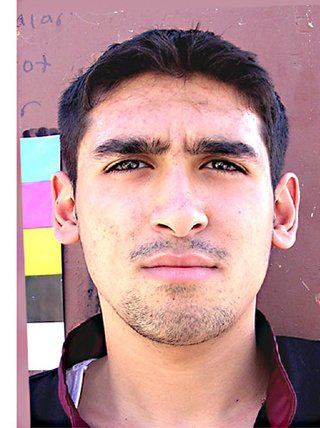

In [8]:
# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

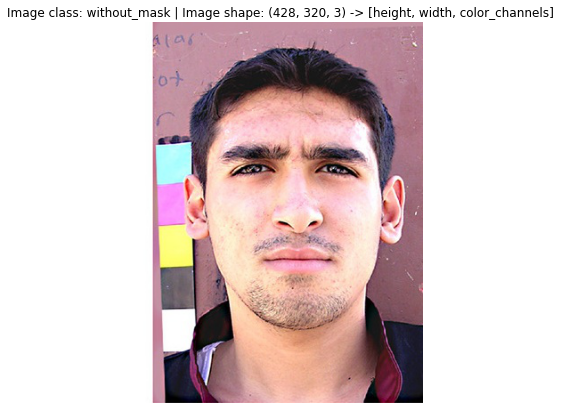

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)


# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [11]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Create Functions for Training and Testing Model

In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X, y

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def val_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module):
    # Put model in train mode
    model.eval()
    
    # Setup train loss and train accuracy values
    val_loss, val_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        val_loss += loss.item() 

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        val_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [14]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
          
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [15]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader, 
          #test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [16]:
from typing import Tuple, Dict, List

In [17]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

### Transfer Learning

In [18]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

### Data Preparation/Transformation

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [20]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=auto_transforms 
                                  ) 
            
val_data = datasets.ImageFolder(root=val_dir,
                                  transform=auto_transforms 
                                  )

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nVal data:\n{val_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 700
    Root location: drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Val data:
Dataset ImageFolder
    Number of datapoints: 206
    Root location: drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/val
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 100
    Root location: drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test
    StandardTransform
Transform: ImageClas

In [21]:
class_names = train_data.classes
class_names

['with_mask', 'without_mask']

In [22]:
# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

val_dataloader = DataLoader(val_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, val_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f7ad14f9dd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7ad1fdddd0>)

In [23]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [24]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [25]:
# Set the manual seeds
torch.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True))

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [27]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train Model

In [28]:
# Set the random seeds
torch.manual_seed(42)


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4675 | train_acc: 0.8263 | val_loss: 0.3609 | val_acc: 0.8737
Epoch: 2 | train_loss: 0.2370 | train_acc: 0.9489 | val_loss: 0.3215 | val_acc: 0.8520
Epoch: 3 | train_loss: 0.1687 | train_acc: 0.9631 | val_loss: 0.2884 | val_acc: 0.8680
Epoch: 4 | train_loss: 0.1418 | train_acc: 0.9744 | val_loss: 0.2669 | val_acc: 0.8737
Epoch: 5 | train_loss: 0.1217 | train_acc: 0.9773 | val_loss: 0.2564 | val_acc: 0.8903
[INFO] Total training time: 319.574 seconds


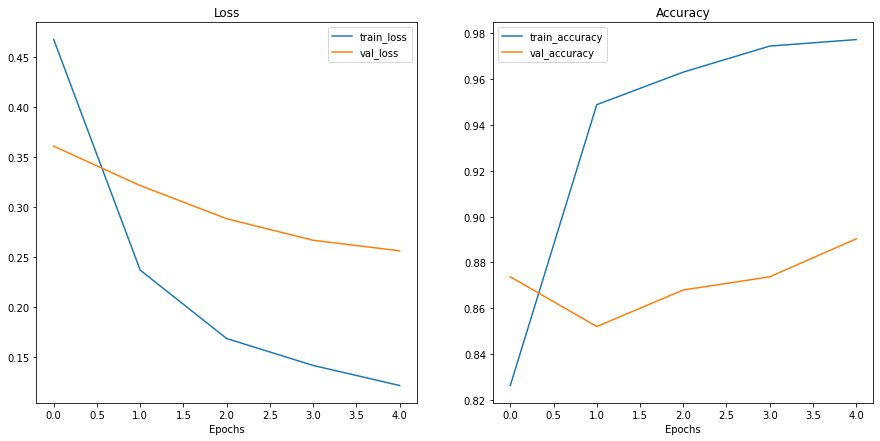

In [29]:
plot_loss_curves(results)

### Test Model

In [30]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test


[PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2072.jpg'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2086.jpg'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2070.jpg'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2085.jpg'),
 PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2083.jpg')]

In [31]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str]) -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0)
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [32]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=model,
                                          transform=auto_transforms,
                                          class_names=class_names) 

  0%|          | 0/60 [00:00<?, ?it/s]

In [33]:
effnetb2_test_pred_dicts[:20]

[{'image_path': PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2072.jpg'),
  'class_name': 'with_mask',
  'pred_prob': 0.9664,
  'pred_class': 'with_mask',
  'time_for_pred': 0.6169,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2086.jpg'),
  'class_name': 'with_mask',
  'pred_prob': 0.9974,
  'pred_class': 'with_mask',
  'time_for_pred': 0.3426,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2070.jpg'),
  'class_name': 'with_mask',
  'pred_prob': 0.9036,
  'pred_class': 'with_mask',
  'time_for_pred': 0.375,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/Colab Notebooks/Elevate/data/mask_unmask/test/with_mask/2085.jpg'),
  'class_name': 'with_mask',
  'pred_prob': 0.9865,
  'pred_class': 'with_mask',
  'time_for_pred': 0.4961,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/Colab Notebo

In [34]:
test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
print(f'Test loss: {test_loss} || Test acc: {test_acc}')

Test loss: 0.1659313216805458 || Test acc: 0.9453125


### Save Model

In [35]:
torch.save(model.state_dict(), 'mask_classifier.pt')